In [73]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [74]:
# Normalizing our data
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [75]:
# Preparing lables via one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, SeparableConv2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.regularizers import l2  

model = Sequential()

# First convolutional block
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
    
# Second convolutional block
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))
    
# Third convolutional block
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
    
# Dense layers
model.add(Flatten())
model.add(Dense(1024, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(512, kernel_regularizer=l2(5e-4)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [78]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0

In [79]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss function for multi-class classification.
    
    Args:
        gamma (float): Focusing parameter. Higher values put more focus on hard-to-classify samples.
        alpha (float): Balancing factor to reduce the impact of easy negatives and amplify the importance of hard positives.
    
    Returns:
        Loss function to be used with model.compile.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent log(0) error
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Compute the cross-entropy loss
        ce_loss = -y_true * K.log(y_pred)
        
        # Calculate the focal loss component
        loss = alpha * K.pow(1 - y_pred, gamma) * ce_loss
        
        # Return the mean loss across all samples
        return K.sum(loss, axis=1)
    
    return focal_loss_fixed

model.compile(loss=focal_loss(gamma=2.0, alpha=0.25),
              optimizer='adam',
              metrics = ['accuracy'])

In [80]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the ReduceLROnPlateau callback
lr_reduction = ReduceLROnPlateau(monitor='val_loss',   # Monitor validation loss
                                 patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
                                 factor=0.5,           # Factor by which the learning rate will be reduced. New_lr = lr * factor
                                 min_lr=1e-6)          # Lower bound on the learning rate
early_stopper = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=5,                # Number of epochs with no improvement after which training stops
    restore_best_weights=True  # Restore the best weights observed during training
)

In [81]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights to adjust the loss function based on the training data
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train.argmax(axis=1)),
                                     y=y_train.argmax(axis=1))
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict[3] *= 2 
class_weights_dict[5] *= 2 

In [82]:
cifar_trained = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test),class_weight=class_weights_dict, callbacks=[lr_reduction, early_stopper])

Epoch 1/100


2024-09-26 08:40:17.628679: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


391/391 [==============================] - 24s 52ms/step - loss: 1.5700 - accuracy: 0.1052 - val_loss: 1.8271 - val_accuracy: 0.0762 - lr: 0.0010
Epoch 2/100
391/391 [==============================] - 21s 53ms/step - loss: 0.7676 - accuracy: 0.1010 - val_loss: 1.1799 - val_accuracy: 0.1137 - lr: 0.0010
Epoch 3/100
391/391 [==============================] - 21s 53ms/step - loss: 0.7639 - accuracy: 0.1037 - val_loss: 1.6997 - val_accuracy: 0.1206 - lr: 0.0010
Epoch 4/100
391/391 [==============================] - 21s 52ms/step - loss: 0.7129 - accuracy: 0.1024 - val_loss: 2.1784 - val_accuracy: 0.1399 - lr: 0.0010
Epoch 5/100
391/391 [==============================] - 20s 52ms/step - loss: 0.7237 - accuracy: 0.1019 - val_loss: 3.8095 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 6/100
391/391 [==============================] - 20s 52ms/step - loss: 0.6568 - accuracy: 0.1037 - val_loss: 0.6271 - val_accuracy: 0.1000 - lr: 5.0000e-04
Epoch 7/100
391/391 [==============================] - 20s 5

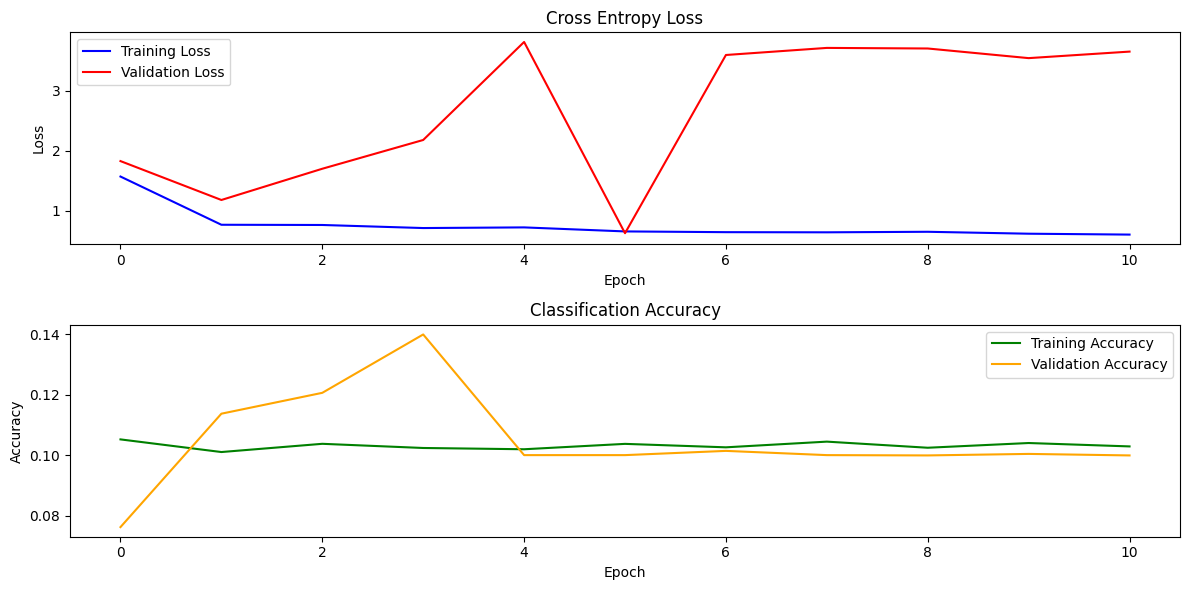

In [83]:
# Plotting the Cross Entropy Loss and Classification Accuracy
plt.figure(figsize=(12, 6))

# Plot Cross Entropy Loss
plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(cifar_trained.history['loss'], color='blue', label='Training Loss')
plt.plot(cifar_trained.history['val_loss'], color='red', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Classification Accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(cifar_trained.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(cifar_trained.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


313/313 [==============================] - 1s 2ms/step


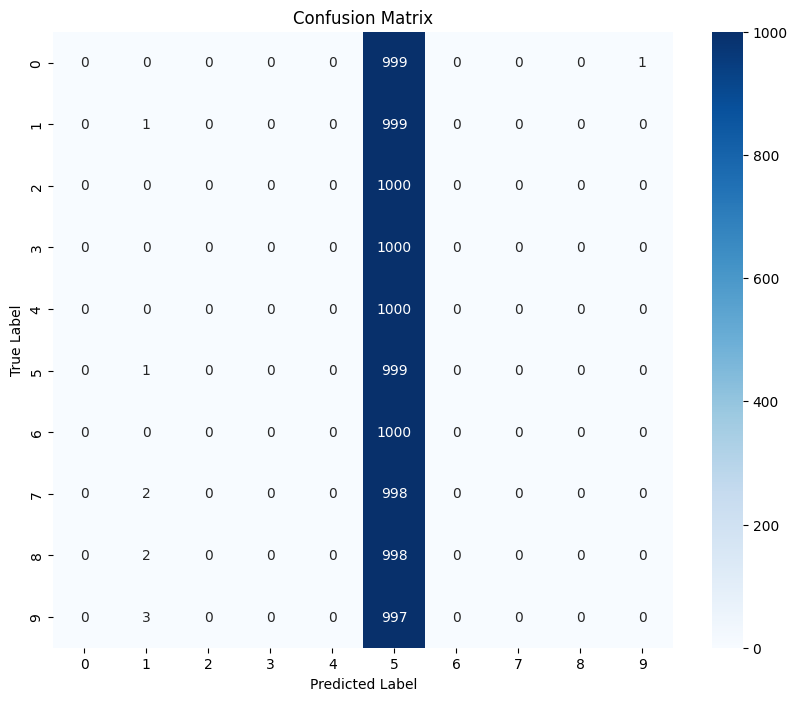

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate predictions and true labels
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
gt = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(gt, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [85]:
train_loss, train_acc = model.evaluate(x_train, y_train)
print('Test loss:', train_loss)
print('Test accuracy:', train_acc)
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

1563/1563 [==============================] - 4s 3ms/step - loss: 0.6278 - accuracy: 0.1001
Test loss: 0.6277669668197632
Test accuracy: 0.10010000318288803
313/313 [==============================] - 1s 3ms/step - loss: 0.6271 - accuracy: 0.1000
Test loss: 0.6270732283592224
Test accuracy: 0.10000000149011612


1/1 [==============================] - 0s 96ms/step


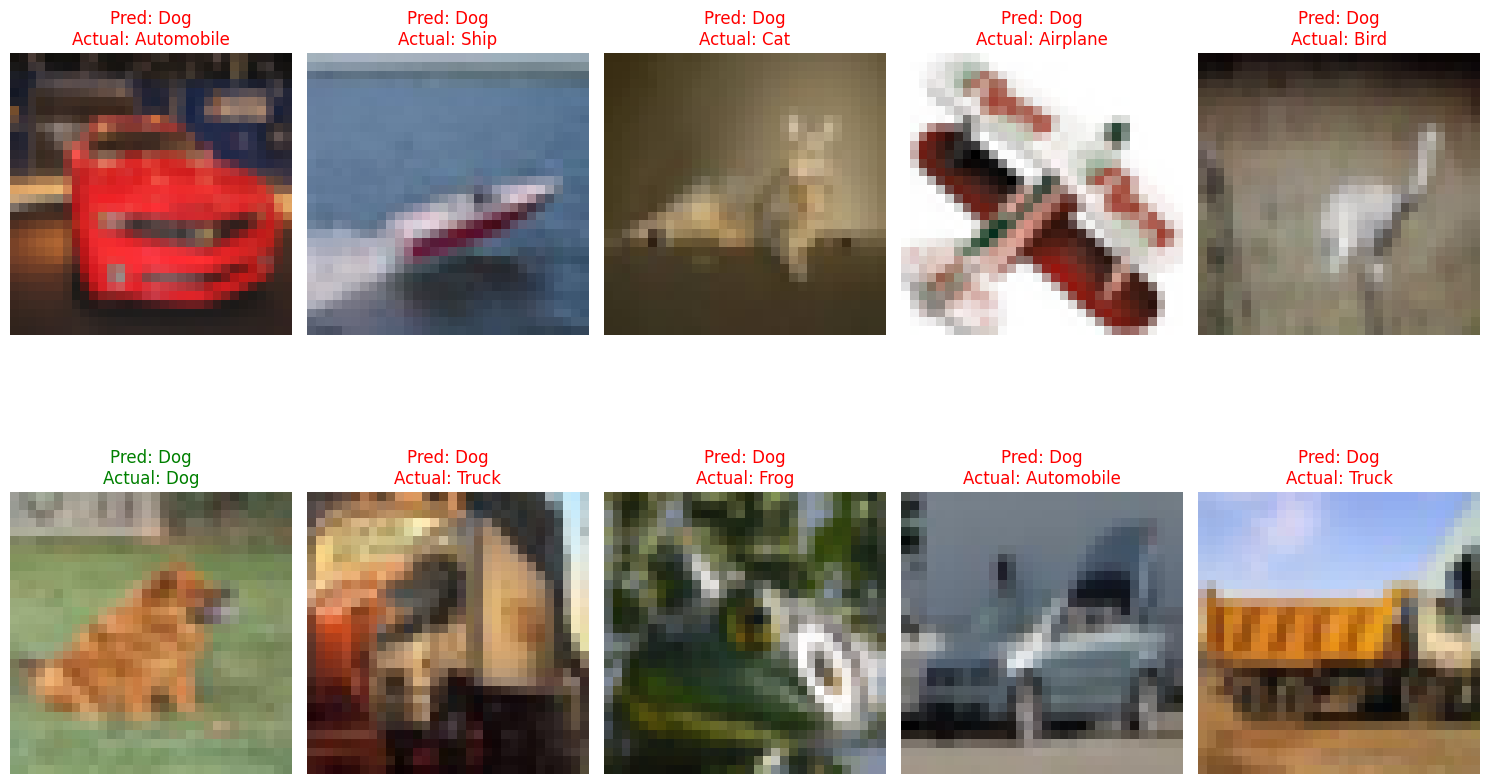

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Class names for CIFAR-10
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Function to display random images with their predictions and actual labels
def display_random_predictions(x_test, y_test, model, class_names):
    # Select 10 random indices from the test set
    random_indices = random.sample(range(x_test.shape[0]), 10)
    
    # Create a figure for plotting
    plt.figure(figsize=(15, 10))
    
    for i, idx in enumerate(random_indices):
        # Get the actual image and label
        image = x_test[idx]
        actual_label = np.argmax(y_test[idx])
        
        # Predict the class of the image
        prediction = model.predict(np.expand_dims(image, axis=0))  # Expand dimensions to match model input
        predicted_label = np.argmax(prediction[0])
        
        # Plot the image
        plt.subplot(2, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        
        # Set the title with predicted and actual labels
        title_color = 'green' if predicted_label == actual_label else 'red'  # Green if correct, red if incorrect
        plt.title(f"Pred: {class_names[predicted_label]}\nActual: {class_names[actual_label]}", color=title_color)
    
    plt.tight_layout()
    plt.show()

# Call the function to display the images
display_random_predictions(x_test, y_test, model, class_names)

In [87]:
from keras.backend import clear_session
clear_session()